In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt

In [4]:
sys.path.append('../codes')

In [15]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

### Generates Empirical Data

We want a notebook that does the following:
1. create a list of chemical
2. create a new mass spec object, takes chemicals
3. create a new controller, takes mass spec
4. write mzml files

Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [16]:
ps = load_obj('../models/peak_sampler_4_beers.p')

Load chromatogram data exported from R

In [17]:
xcms_output = '../models/beer_ms1_peaks.csv.gz'
chromatograms = ChromatogramCreator(xcms_output)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [19]:
chemicals = ChemicalCreator(ps, chromatograms)

In [23]:
min_ms1_intensity = 2E5
min_rt = 3*60
max_rt = 21*60
dataset = chemicals.sample(min_rt, max_rt, min_ms1_intensity, 100, 2, "Unknown","Empirical",None, False)

Plot some chemicals

UnknownChemical mz=188.1677 rt=404.56 max_intensity=1.00


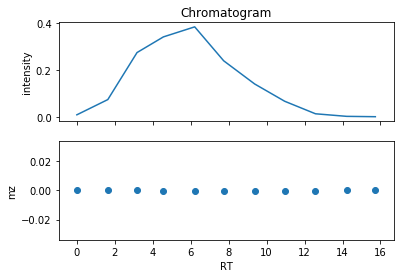

UnknownChemical mz=164.0488 rt=378.05 max_intensity=1.00


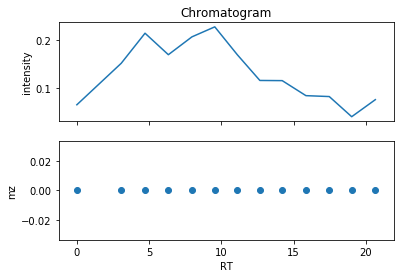

UnknownChemical mz=155.4685 rt=226.00 max_intensity=1.00


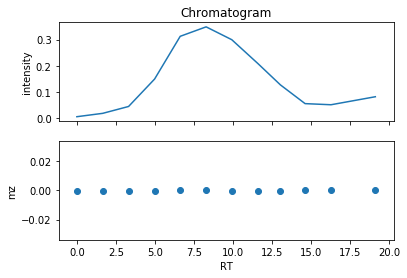

UnknownChemical mz=171.1501 rt=477.19 max_intensity=1.00


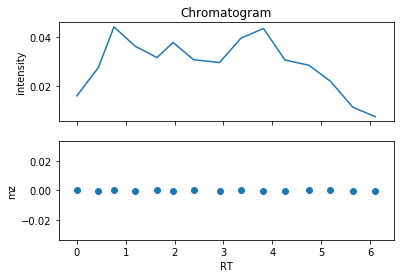

UnknownChemical mz=358.3033 rt=596.83 max_intensity=1.00


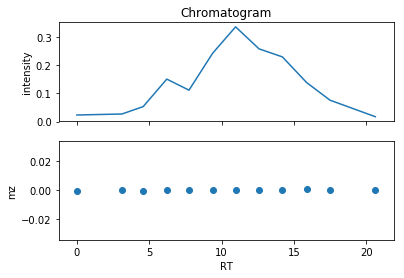

UnknownChemical mz=276.3728 rt=599.62 max_intensity=1.00


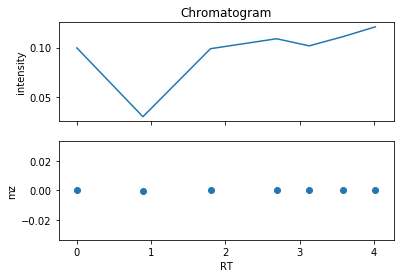

UnknownChemical mz=162.6883 rt=831.92 max_intensity=1.00


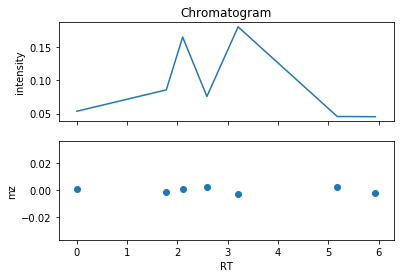

UnknownChemical mz=366.0946 rt=908.62 max_intensity=1.00


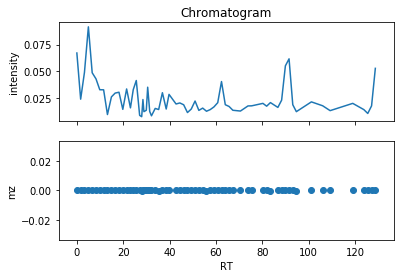

UnknownChemical mz=139.2905 rt=768.44 max_intensity=1.00


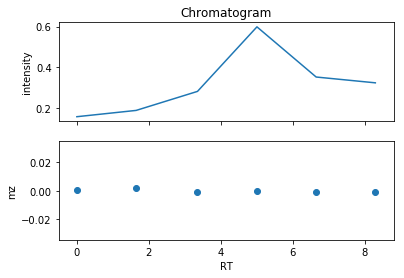

UnknownChemical mz=122.3096 rt=683.32 max_intensity=1.00


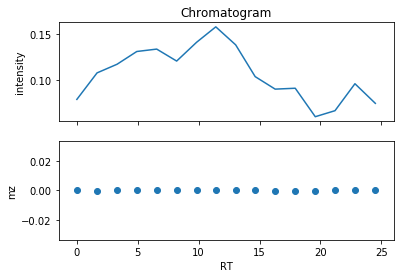

In [26]:
def plot_chromatogram(chrom):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(chrom.rts, chrom.intensities)
    axarr[0].set_title('Chromatogram')
    axarr[0].set_ylabel('intensity')
    axarr[1].scatter(chrom.rts, chrom.mzs)
    axarr[1].set_ylabel('mz')
    axarr[1].set_xlabel('RT')    
    plt.show()

for chem in dataset[0:10]:
    print(chem)
    plot_chromatogram(chem.chromatogram)

Connect the column to a simple mass spec controller that returns a scan every time we call it.

In [11]:
def scan_handler(scan):
    if scan.num_peaks > 0:
        print(scan)
    
def acquisition_open():
    print('Start acquisition')
    
def acquisition_closing():
    print('End acquisition')

In [27]:
sampled_chemicals = chemicals.sample(min_rt, max_rt, min_ms1_intensity, 100, 2, "Unknown","Empirical",None, False)
scan_parameters = {
    'isolation_windows': [[(0, 1e3)]], # TODO: change to dictionary?
    'ms_level': 1
}    
mass_spec = IndependentMassSpectrometer(sampled_chemicals, scan_parameters)
mass_spec.register(MassSpectrometer.MS_SCAN_ARRIVED, scan_handler)
mass_spec.register(MassSpectrometer.ACQUISITION_STREAM_OPENING, acquisition_open)
mass_spec.register(MassSpectrometer.ACQUISITION_STREAM_CLOSING, acquisition_closing)
mass_spec.run(max_rt)

Start acquisition
Scan 205 -- num_peaks=1 rt=205.00 ms_level=1
Scan 206 -- num_peaks=1 rt=206.00 ms_level=1
Scan 207 -- num_peaks=1 rt=207.00 ms_level=1
Scan 208 -- num_peaks=1 rt=208.00 ms_level=1
Scan 209 -- num_peaks=1 rt=209.00 ms_level=1
Scan 210 -- num_peaks=1 rt=210.00 ms_level=1
Scan 211 -- num_peaks=1 rt=211.00 ms_level=1
Scan 212 -- num_peaks=1 rt=212.00 ms_level=1
Scan 213 -- num_peaks=1 rt=213.00 ms_level=1
Scan 214 -- num_peaks=1 rt=214.00 ms_level=1
Scan 215 -- num_peaks=1 rt=215.00 ms_level=1
Scan 216 -- num_peaks=2 rt=216.00 ms_level=1
Scan 217 -- num_peaks=2 rt=217.00 ms_level=1
Scan 218 -- num_peaks=2 rt=218.00 ms_level=1
Scan 219 -- num_peaks=2 rt=219.00 ms_level=1
Scan 220 -- num_peaks=2 rt=220.00 ms_level=1
Scan 221 -- num_peaks=1 rt=221.00 ms_level=1
Scan 222 -- num_peaks=1 rt=222.00 ms_level=1
Scan 223 -- num_peaks=1 rt=223.00 ms_level=1
Scan 224 -- num_peaks=1 rt=224.00 ms_level=1
Scan 225 -- num_peaks=2 rt=225.00 ms_level=1
Scan 226 -- num_peaks=2 rt=226.00 ms_

Scan 575 -- num_peaks=5 rt=575.00 ms_level=1
Scan 576 -- num_peaks=5 rt=576.00 ms_level=1
Scan 577 -- num_peaks=4 rt=577.00 ms_level=1
Scan 578 -- num_peaks=4 rt=578.00 ms_level=1
Scan 579 -- num_peaks=4 rt=579.00 ms_level=1
Scan 580 -- num_peaks=3 rt=580.00 ms_level=1
Scan 581 -- num_peaks=3 rt=581.00 ms_level=1
Scan 582 -- num_peaks=2 rt=582.00 ms_level=1
Scan 583 -- num_peaks=2 rt=583.00 ms_level=1
Scan 584 -- num_peaks=2 rt=584.00 ms_level=1
Scan 585 -- num_peaks=2 rt=585.00 ms_level=1
Scan 586 -- num_peaks=2 rt=586.00 ms_level=1
Scan 587 -- num_peaks=3 rt=587.00 ms_level=1
Scan 588 -- num_peaks=2 rt=588.00 ms_level=1
Scan 589 -- num_peaks=2 rt=589.00 ms_level=1
Scan 590 -- num_peaks=2 rt=590.00 ms_level=1
Scan 591 -- num_peaks=2 rt=591.00 ms_level=1
Scan 592 -- num_peaks=2 rt=592.00 ms_level=1
Scan 593 -- num_peaks=2 rt=593.00 ms_level=1
Scan 594 -- num_peaks=2 rt=594.00 ms_level=1
Scan 595 -- num_peaks=1 rt=595.00 ms_level=1
Scan 596 -- num_peaks=1 rt=596.00 ms_level=1
Scan 597 -

Scan 1107 -- num_peaks=3 rt=1107.00 ms_level=1
Scan 1108 -- num_peaks=4 rt=1108.00 ms_level=1
Scan 1109 -- num_peaks=4 rt=1109.00 ms_level=1
Scan 1110 -- num_peaks=4 rt=1110.00 ms_level=1
Scan 1111 -- num_peaks=4 rt=1111.00 ms_level=1
Scan 1112 -- num_peaks=4 rt=1112.00 ms_level=1
Scan 1113 -- num_peaks=4 rt=1113.00 ms_level=1
Scan 1114 -- num_peaks=4 rt=1114.00 ms_level=1
Scan 1115 -- num_peaks=4 rt=1115.00 ms_level=1
Scan 1116 -- num_peaks=4 rt=1116.00 ms_level=1
Scan 1117 -- num_peaks=2 rt=1117.00 ms_level=1
Scan 1118 -- num_peaks=2 rt=1118.00 ms_level=1
Scan 1119 -- num_peaks=2 rt=1119.00 ms_level=1
Scan 1120 -- num_peaks=2 rt=1120.00 ms_level=1
Scan 1121 -- num_peaks=3 rt=1121.00 ms_level=1
Scan 1122 -- num_peaks=3 rt=1122.00 ms_level=1
Scan 1123 -- num_peaks=3 rt=1123.00 ms_level=1
Scan 1124 -- num_peaks=3 rt=1124.00 ms_level=1
Scan 1125 -- num_peaks=2 rt=1125.00 ms_level=1
Scan 1126 -- num_peaks=2 rt=1126.00 ms_level=1
Scan 1127 -- num_peaks=2 rt=1127.00 ms_level=1
Scan 1128 -- 

Set up a simple controller

In [32]:
controller = SimpleMs1Controller(sampled_chemicals)
controller.run(max_rt)

100
Acquisition open
Acquisition closing
